# Detection Of Plastic Bottles

In this colab notebook, you will know how to use Detectron2 to train a Mask-RCNN model from our image dataset. You can also import your own dataset for training too.

## Preparing the Dataset

First, let's import our plastic bottle dataset to the cloud directory. The dataset imported should be in [COCO format](https://towardsdatascience.com/how-to-work-with-object-detection-datasets-in-coco-format-9bf4fb5848a4). Where there should be two folders - `images` and `annotations` appearing in your working directory.


In [ ]:
# !wget (path to be defined)
# !unzip main.zip > /dev/null

The imported files should be in the follwing format:
```
∟annotations
 ∟instances_train.json
 ∟instances_val.json
∟images
  ∟Image.jpg
  ∟Image2.jpg
  ∟...
```



You may notice that there are two annotation json file in the `annotations` folder. For your reference, `instances_train.json` is for training, and `isntances_val.json` is for validation.

In case if you want to import your own dataset, you need to connect this notebook to your google drive to access your dataset files. (uncomment the code to run it)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

## Import required libaries
Below code downloads all the required libaries(including detectron) to the google colab notebook.

When you first run the below code, you might get an error:


```
AssertionError 
Traceback (most recent call last) <ipython-input-1-941f8314d956> in <module>() 9 # See https://detectron2.readthedocs.io/tutorials/install.html for instructions 10 import torch ---> 11 assert torch.__version__.startswith("1.8") # need to manually install torch 1.8 if Colab changes its default version 12 get_ipython().system('pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html') 13 # exit(0) # After installation, you need to "restart runtime" in Colab. This line can also restart runtime 

AssertionError:
```
This error is caused due to incompatable pytorch version.

Don't panic, just press the restart runtime button and run the program again.

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version


# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import logging
import os
from collections import OrderedDict

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, hooks, launch
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    verify_results,
)
from detectron2.modeling import GeneralizedRCNNWithTTA

from detectron2.data import build_detection_train_loader
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils

import os

!nvidia-smi


1.8.0+cu101 False
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Register the Datasets

Since the datasets are imported in COCO format, we can easily register it using the detectron built-in function.

In [ ]:
from detectron2.data.datasets import register_coco_instances
DatasetCatalog.clear()
path_to_train = "/content/drive/MyDrive/plastic_data/annotations/instances_train.json"
path_to_val = "/content/drive/MyDrive/plastic_data/annotations/instances_val.json"
path_to_ims = "/content/drive/MyDrive/plastic_data/images"

register_coco_instances("PET_train", {}, path_to_train, path_to_ims)         #path to instances_train.json and images
register_coco_instances("PET_val", {}, path_to_val, path_to_ims)

PET_Bottles_metadata = MetadataCatalog.get("PET_train")

For a sanity check, you can run the below code to show the images and its respected labels.

[08/19 13:33:20 d2.data.datasets.coco]: Loaded 144 images in COCO format from /content/drive/MyDrive/plastic_data/annotations/instances_val.json
/content/drive/MyDrive/plastic_data/images/PhoneIM151.jpg


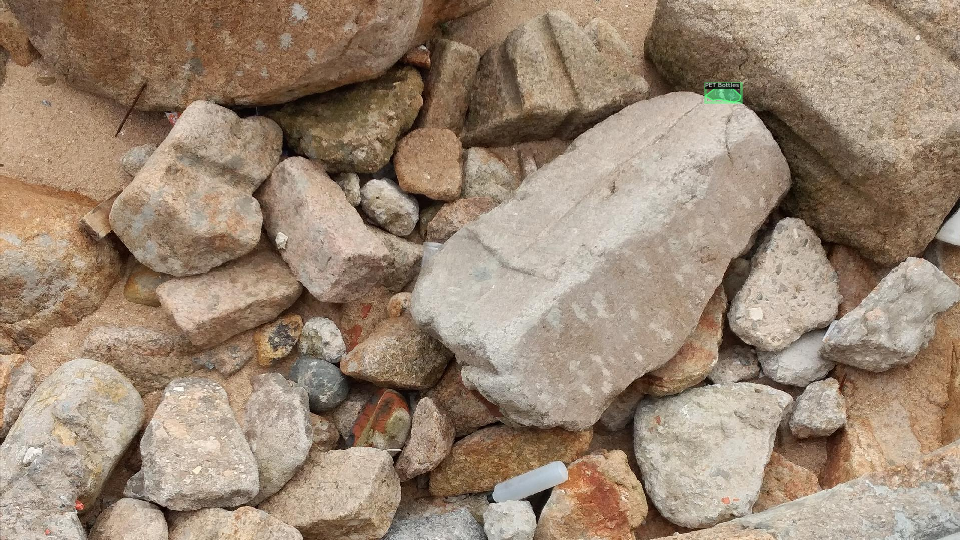

/content/drive/MyDrive/plastic_data/images/PhoneIM162.jpg


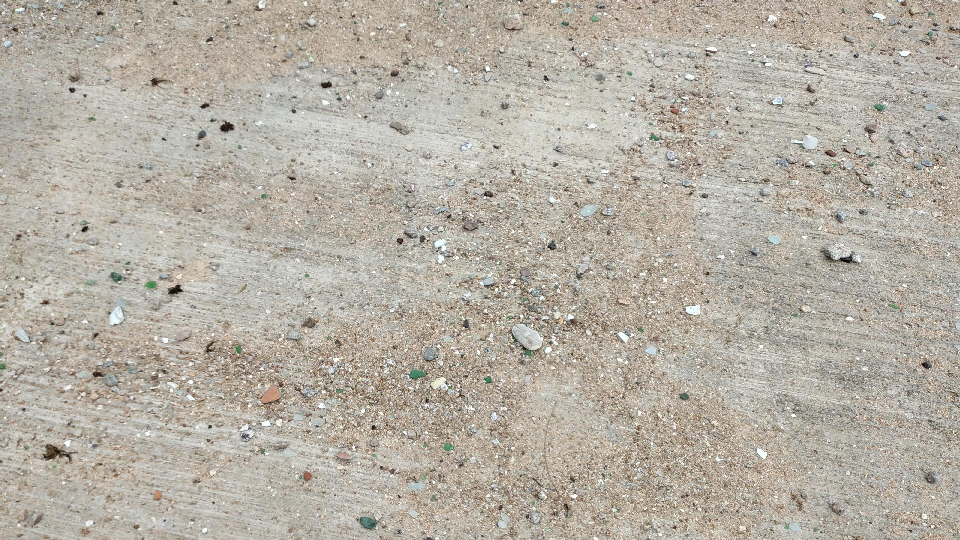

/content/drive/MyDrive/plastic_data/images/PhoneIM114.jpg


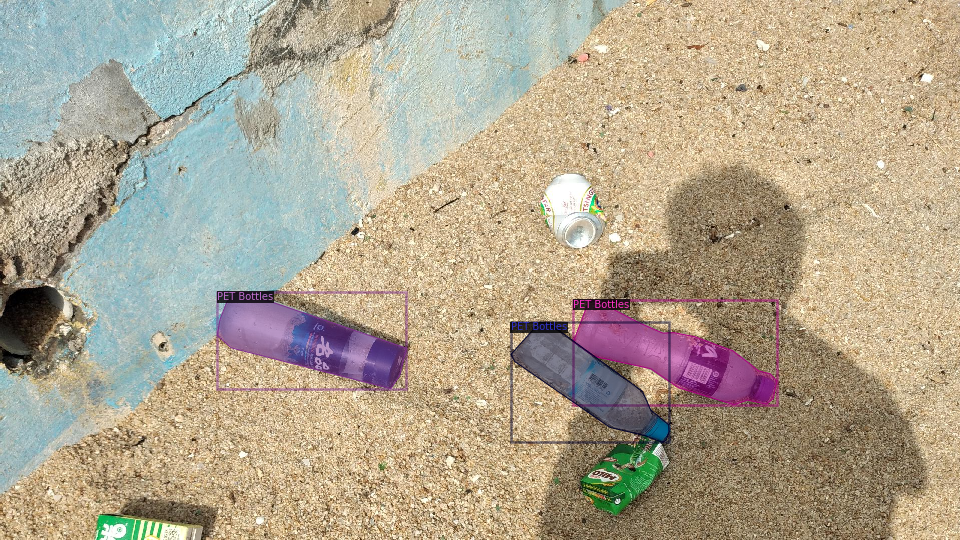

/content/drive/MyDrive/plastic_data/images/PhoneIM149.jpg


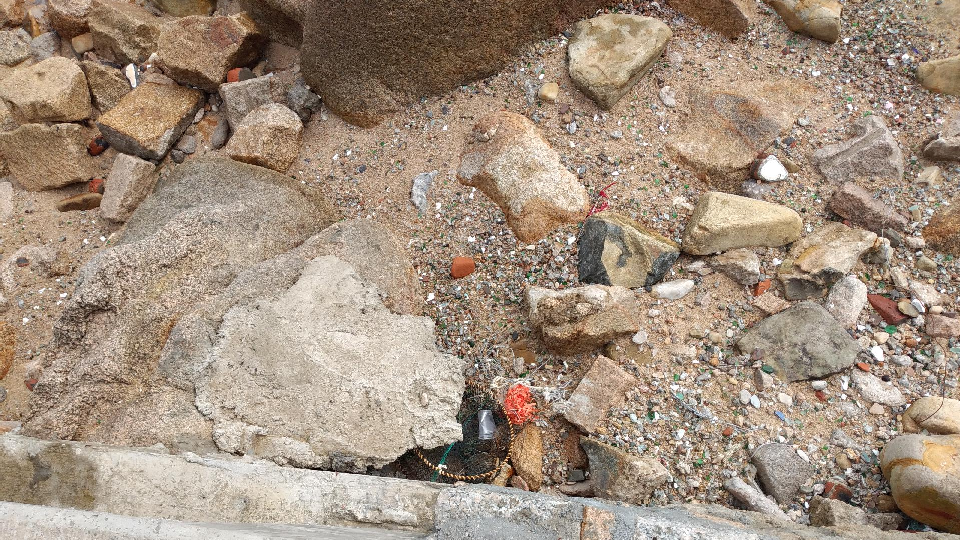

/content/drive/MyDrive/plastic_data/images/PhoneIM155.jpg


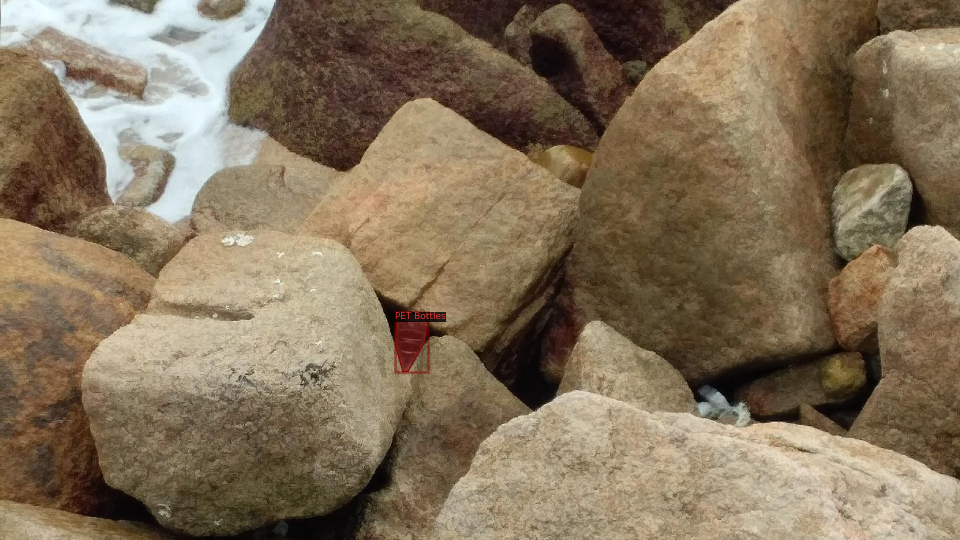

In [ ]:
dataset_dicts = DatasetCatalog.get("PET_val")
PET_Bottles_metadata = MetadataCatalog.get("PET_val")

for d in random.sample(dataset_dicts, 5):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=PET_Bottles_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Training the model

In the below code, you can alter the training configurations.
You can refer to https://detectron2.readthedocs.io/en/latest/modules/config.html for details

In [ ]:
def create_cfg():
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
  cfg.DATASETS.TRAIN = ("PET_train",)
  cfg.DATASETS.TEST = ("PET_val",)
  cfg.DATALOADER.NUM_WORKERS = 2
  cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") 
  cfg.SOLVER.IMS_PER_BATCH = 8               #BATCH_SIZE
  cfg.SOLVER.BASE_LR = 0.00025
  cfg.SOLVER.STEPS = []
  cfg.SOLVER.MAX_ITER = 1000                ##epoch = MAX_ITER * BATCH_SIZE / TOTAL_NUM_IMAGES
  '''For reference, 1000 MAX ITER need 2 hours to train for me, feel free to change it'''

  cfg.SOLVER.CHECKPOINT_PERIOD = 5000
  cfg.TEST.EVAL_PERIOD = 20                 ##change this for evaluation
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128      ##proposals per image 
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 
  #cfg.MODEL.DEVICE = "cpu" # Comment out if using GPU

  cfg.OUTPUT_DIR = "./output"

  return cfg

cfg = create_cfg()

Below code starts the training process as well as the validation. For a higher training speed, make sure that the runtime of this notebook is in GPU.

In [ ]:
#create trainer for evalution per iteration
from detectron2.data import DatasetMapper

class Trainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains pre-defined default logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can write your
    own training loop. You can use "tools/plain_train_net.py" as an example.
    """

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        Create evaluator(s) for a given dataset.
        This uses the special metadata "evaluator_type" associated with each builtin dataset.
        For your own dataset, you can simply create an evaluator manually in your
        script and do not have to worry about the hacky if-else logic here.
        """
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        evaluator_list = []
        evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
        if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
            evaluator_list.append(
                SemSegEvaluator(
                    dataset_name,
                    distributed=True,
                    output_dir=output_folder,
                )
            )
        if evaluator_type in ["coco", "coco_panoptic_seg"]:
            evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
        if evaluator_type == "coco_panoptic_seg":
            evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
        if evaluator_type == "cityscapes_instance":
            assert (
                torch.cuda.device_count() >= comm.get_rank()
            ), "CityscapesEvaluator currently do not work with multiple machines."
            return CityscapesInstanceEvaluator(dataset_name)
        if evaluator_type == "cityscapes_sem_seg":
            assert (
                torch.cuda.device_count() >= comm.get_rank()
            ), "CityscapesEvaluator currently do not work with multiple machines."
            return CityscapesSemSegEvaluator(dataset_name)
        elif evaluator_type == "pascal_voc":
            return PascalVOCDetectionEvaluator(dataset_name)
        elif evaluator_type == "lvis":
            return LVISEvaluator(dataset_name, output_dir=output_folder)
        if len(evaluator_list) == 0:
            raise NotImplementedError(
                "no Evaluator for the dataset {} with the type {}".format(
                    dataset_name, evaluator_type
                )
            )
        elif len(evaluator_list) == 1:
            return evaluator_list[0]
        return DatasetEvaluators(evaluator_list)

    @classmethod
    def test_with_TTA(cls, cfg, model):
        logger = logging.getLogger("detectron2.trainer")
        # In the end of training, run an evaluation with TTA
        # Only support some R-CNN models.
        logger.info("Running inference with test-time augmentation ...")
        model = GeneralizedRCNNWithTTA(cfg, model)
        evaluators = [
            cls.build_evaluator(
                cfg, name, output_folder=os.path.join(cfg.OUTPUT_DIR, "inference_TTA")
            )
            for name in cfg.DATASETS.TEST
        ]
        res = cls.test(cfg, model, evaluators)
        res = OrderedDict({k + "_TTA": v for k, v in res.items()})
        return res

    @classmethod
    def build_train_loader(cls, cfg):                #train loader for data augmentation
      return build_detection_train_loader(cfg,
        mapper=DatasetMapper(cfg, is_train=True, augmentations=[
            T.RandomBrightness(0.9,1.1),
            T.RandomContrast(0.9, 1.1),
            T.RandomBrightness(0.9, 1.1),
            T.RandomFlip(prob=0.5),
            T.Resize((720,1280))
        ]))

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)                  ##TODO: GET A GPU
trainer.resume_or_load(resume=False)
if cfg.TEST.AUG.ENABLED:
  trainer.register_hooks(
    [hooks.EvalHook(0, lambda: trainer.test_with_TTA(cfg, trainer.model))]   #this block uses a hook to run evalutaion periodically
  )                                           #https://detectron2.readthedocs.io/en/latest/modules/engine.html#detectron2.engine.hooks.EvalHook
trainer.train()

[08/19 11:20:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:24, 10.3MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[08/19 11:21:22 d2.engine.train_loop]: Starting training from iteration 0
[08/19 11:22:09 d2.data.datasets.coco]: Loaded 191 images in COCO format from /content/drive/MyDrive/plastic_data/annotations/instances_val.json
[08/19 11:22:09 d2.data.build]: Distribution of instances among all 1 categories:
|  category   | #instances   |
|:-----------:|:-------------|
| PET Bottles | 367          |
|             |              |
[08/19 11:22:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/19 11:22:09 d2.data.common]: Serializing 191 elements to byte tensors and concatenating them all ...
[08/19 11:22:09 d2.data.common]: Serialized dataset takes 0.16 MiB
[08/19 11:22:09 d2.evaluation.evaluator]: Start inference on 191 batches
[08/19 11:22:24 d2.evaluation.evaluator]: Inference done 11/191. Dataloading: 0.0021 s/iter. Inference: 0.7143 s/iter. Eval: 0.6039 s/iter. Total: 1.32

KeyboardInterrupt: ignored

## Analysing the model

Below code uses Tensorboard to access the preformance of the model

In [ ]:
%tensorboard --logdir output

## Using the model

After training the model, there should be a new file and inside the `output` folder called `model_final.pth`. This file saves all the weights of the model's neural network. We've also imported a test datset. You can run the below code to test how the model preform on it.

In [ ]:
from detectron2.utils.visualizer import ColorMode

cfg.MODEL.WEIGHTS = "/output/model_final.pth"           # path to model_final.pth
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7            # set a custom testing threshold
predictor = DefaultPredictor(cfg)

frames_to_be_detected = "/content/test_images"

for d in os.listdir(frames_to_be_detected):    
    print(d)
    im = cv2.imread(os.path.join(im_path, d))
    outputs = predictor(im)                     # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=PET_Bottles_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

## Utilities

### Joining multiple COCO datsets

Organize your files to the following format

```
Folder
∟annotations
 ∟annotations1.json
 ∟annotations2.json
 ∟...
∟images
  ∟Image.jpg
  ∟Image2.jpg
  ∟...
```

Then change the `path_to_anno` variable to the path of `Folder`.
After running the program, it should generate one json for training and one json for validation.



In [ ]:
import os, json

def join_split_datasets(dir, split, total_images):
  annos_path = os.path.join(dir, "not_joined")
  image_path = os.path.join(dir, "images")
  train_json = {
    "info" : None,
    "licenses" : None,
    "categories" :None,
    "images" : [],
    "annotations" : []
  }
  val_json = {
    "info" : None,
    "licenses" : None,
    "categories" :None,
    "images" : [],
    "annotations" : []
  }
  print(total_images)
  id, id_anno = 1,1
  for anno_json_head in os.listdir(annos_path):

    print(annos_path + "/" + anno_json_head)
    anno_json = json.load(open(annos_path + "/" + anno_json_head))

    train_json["info"] = anno_json["info"]
    train_json["licenses"] = anno_json["licenses"]
    train_json["categories"] = anno_json["categories"]

    val_json["info"] = anno_json["info"]
    val_json["licenses"] = anno_json["licenses"]
    val_json["categories"] = anno_json["categories"]
      
    for image_info in anno_json["images"]:
      #adding image info
      if(id > total_images * split):
        val_json["images"].append({            
            "id": id,
            "license": 1,
            "file_name": image_info["file_name"],
            "height": image_info["height"],
            "width": image_info["width"],
            "date_captured": None
        })
      else:
        train_json["images"].append({            
            "id": id,
            "license": 1,
            "file_name": image_info["file_name"],
            "height": image_info["height"],
            "width": image_info["width"],
            "date_captured": None
        })

      current_image_id = image_info["id"]

      #adding catagories
      for anno_info in anno_json["annotations"]:
        if anno_info["image_id"] == current_image_id:
          if(id > total_images * split):
            val_json["annotations"].append({
              "id": id_anno,
              "image_id": id,
              "category_id": anno_info["category_id"],
              "bbox": anno_info["bbox"],
              "segmentation": anno_info["segmentation"],
              "area": anno_info["area"],
              "iscrowd": anno_info["iscrowd"]
            })
          else:
            train_json["annotations"].append({
              "id": id_anno,
              "image_id": id,
              "category_id": anno_info["category_id"],
              "bbox": anno_info["bbox"],
              "segmentation": anno_info["segmentation"],
              "area": anno_info["area"],
              "iscrowd": anno_info["iscrowd"]
            })
          id_anno += 1
      
      id += 1

  return train_json, val_json 
path_to_anno = "/content/drive/MyDrive/plastic_data"     #################      HERE!!!!!           

files = join_split_datasets(path_to_anno, 0.8, 718)
with open('instances_train.json', 'w') as json_file:
    json.dump(files[0], json_file,ensure_ascii=False,indent=4)
with open('instances_val.json', 'w') as json_file:
    json.dump(files[1], json_file,ensure_ascii=False,indent=4)


718
/content/drive/MyDrive/plastic_data/not_joined/instances_default.json
/content/drive/MyDrive/plastic_data/not_joined/instances_default5.json
/content/drive/MyDrive/plastic_data/not_joined/instances_default1.json
/content/drive/MyDrive/plastic_data/not_joined/instances_default7.json
/content/drive/MyDrive/plastic_data/not_joined/instances_default6.json
/content/drive/MyDrive/plastic_data/not_joined/instances_default3.json
/content/drive/MyDrive/plastic_data/not_joined/instances_default2.json
/content/drive/MyDrive/plastic_data/not_joined/instances_default4.json


### Random Subsampling

Extracts Subsample from a COCO dataset

In [ ]:

import json, os, random
def rssCOCO(from_dir, sample_size_fraction):
  new_sample = {
    "info" : None,
    "licenses" : None,
    "categories" :None,
    "images" : [],
    "annotations" : []
  }
  from_data = json.load(open(from_dir))
  new_sample["info"] = from_data["info"]
  new_sample["licenses"] = from_data["licenses"]
  new_sample["categories"] = from_data["categories"]

  id_anno = 0

  print("Found", len(from_data["images"]), "images in json file provided")
  print("Randomly sumsampling", int(sample_size_fraction * len(from_data["images"])))

  for count, image_info in enumerate(random.sample(from_data["images"], int(sample_size_fraction * len(from_data["images"])))):
    new_sample["images"].append({
        "id": count,
        "license": 1,
        "file_name": image_info["file_name"],
        "height": image_info["height"],
        "width": image_info["width"],
        "date_captured": None
    })

    for anno_info in from_data["annotations"]:
      if image_info["id"] == anno_info["image_id"]:
        new_sample["annotations"].append({
            "id": id_anno,
            "image_id": count,
            "category_id": anno_info["category_id"],
            "bbox": anno_info["bbox"],
            "segmentation": anno_info["segmentation"],
            "area": anno_info["area"],
            "iscrowd": anno_info["iscrowd"]
        })
        id_anno += 1
      
  return new_sample
  
json_path = "/content/drive/MyDrive/plastic_data/annotations/instances_train.json"
out = rssCOCO(json_path, .75)
with open('subsample75.json', 'w') as json_file:
    json.dump(out, json_file)

In [ ]:
# verify if images exists
train = json.load(open("instances_val.json"))
count = 0 
for i in train["images"]:
  count += 1
  if(not os.path.exists("/content/drive/MyDrive/plastic_data/images/" + i["file_name"])):    #path to image dir to verify
    print(i["file_name"] , "doesn't exist!")
print(count)

144
